In [1]:
import pandas as pd
import seaborn as sns

from s2_analytics import sqlite_import

con, cur = sqlite_import.import_games("logs_ranked/", "/tmp/s2_ranked.sql")

## Summary

In [2]:
query = """
select
    datetime(min(id)/1000, 'unixepoch') first_game_start_time,
    datetime(max(id)/1000, 'unixepoch') last_game_start_time,
    count(1) games_count
from game
"""
pd.read_sql_query(query,
                  con)

,first_game_start_time,last_game_start_time,games_count
0,2022-10-01 19:43:15,2023-01-09 19:58:55,1323


## Maps played

[Text(0.5, 1.0, 'Maps played')]

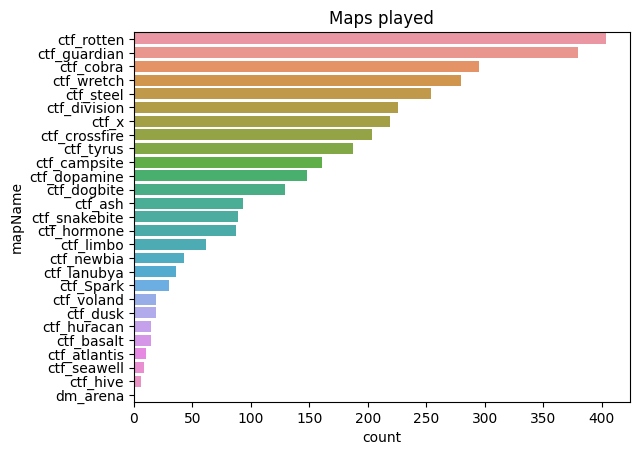

In [3]:
result6 = pd.read_sql_query("select mapName, count(1) as count from round group by mapName order by count desc", con)
sns.barplot(result6,
            y="mapName", x="count").set(title="Maps played")

In [4]:
result6

,mapName,count
0,ctf_rotten,404
1,ctf_guardian,380
2,ctf_cobra,295
3,ctf_wretch,280
4,ctf_steel,254
5,ctf_division,226
6,ctf_x,219
7,ctf_crossfire,204
8,ctf_tyrus,187
9,ctf_campsite,161


## Average cap count per round

[Text(0.5, 1.0, 'Average cap count per round')]

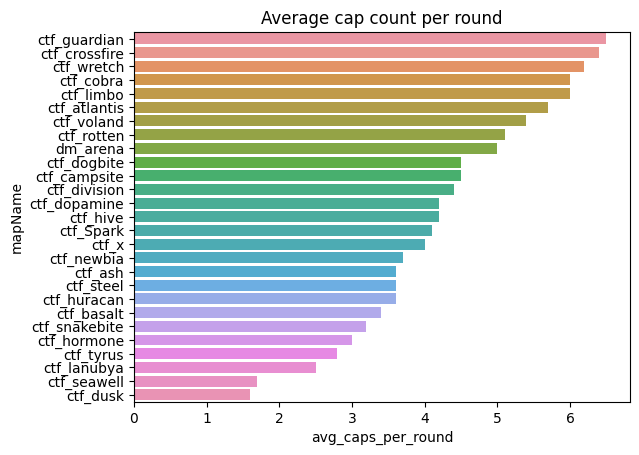

In [5]:
query = """
select distinct mapName,
round(1.0 *
    (select count(1) from event_cap c where r.mapName = c.mapName)/
    (select count(1) from round rr where r.mapName = rr.mapName), 1) avg_caps_per_round
from round r order by avg_caps_per_round desc;
"""
result7 = pd.read_sql_query(query, con)
sns.barplot(result7, y="mapName", x="avg_caps_per_round").set(title="Average cap count per round")

In [6]:
result7

,mapName,avg_caps_per_round
0,ctf_guardian,6.5
1,ctf_crossfire,6.4
2,ctf_wretch,6.2
3,ctf_cobra,6.0
4,ctf_limbo,6.0
5,ctf_atlantis,5.7
6,ctf_voland,5.4
7,ctf_rotten,5.1
8,dm_arena,5.0
9,ctf_dogbite,4.5


In [7]:
## Average rounds per game

[Text(0.5, 1.0, 'Average rounds per game')]

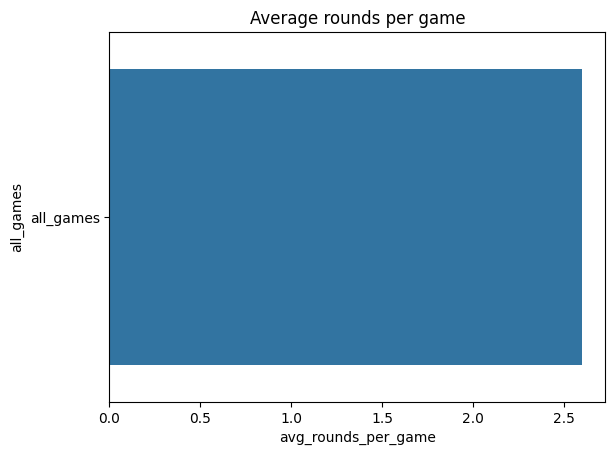

In [8]:
query = """select
"all_games" as all_games,
(select count(distinct game) from round) games_played,
(select count(1) from round) rounds_played,
round(1.0*(select count(1) from round)/(select count(distinct game) from round),1) avg_rounds_per_game
"""
result_rounds_per_game = pd.read_sql_query(query, con)
sns.barplot(result_rounds_per_game, y="all_games", x="avg_rounds_per_game").set(title="Average rounds per game")

In [9]:
result_rounds_per_game

,all_games,games_played,rounds_played,avg_rounds_per_game
0,all_games,1323,3421,2.6


## Round result

[Text(0.5, 1.0, 'Round result')]

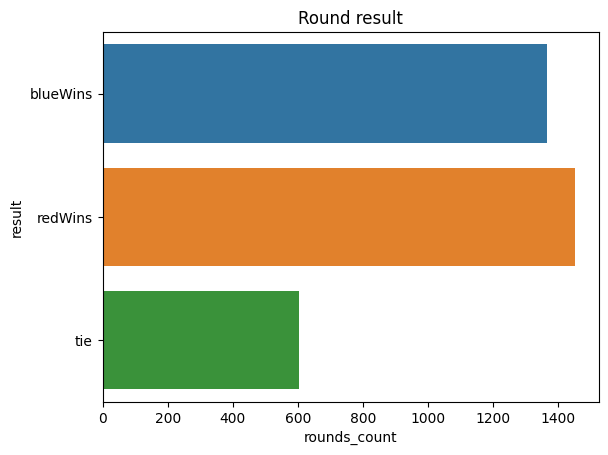

In [10]:
query = """
select result, count(1) rounds_count from round group by result;
"""
result_round_result = pd.read_sql_query(query, con)
sns.barplot(result_round_result, y="result", x="rounds_count", orient="h").set(title="Round result")

## Rounds finished before time limit

[Text(0.5, 1.0, 'Rounds finished before time limit')]

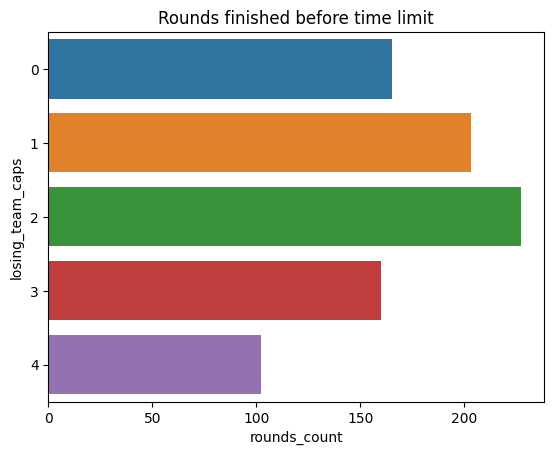

In [11]:
query = """
select
5 - abs(blueCaps - redCaps) losing_team_caps,
count(1) as rounds_count,
round(315 - (1.0*endTime - startTime)/1000,1) seconds_left_avg
from round where blueCaps = 5 or redCaps = 5 group by losing_team_caps;
"""
result_finished_before_limit = pd.read_sql_query(query, con)
sns.barplot(result_finished_before_limit, y="losing_team_caps", x="rounds_count", orient="h").set(title="Rounds finished before time limit")

In [12]:
result_finished_before_limit

,losing_team_caps,rounds_count,seconds_left_avg
0,0,165,23.5
1,1,203,31.8
2,2,227,104.5
3,3,160,98.4
4,4,102,81.1


## Weapons

### Kills per weapon

[Text(0.5, 1.0, 'Kills per weapon')]

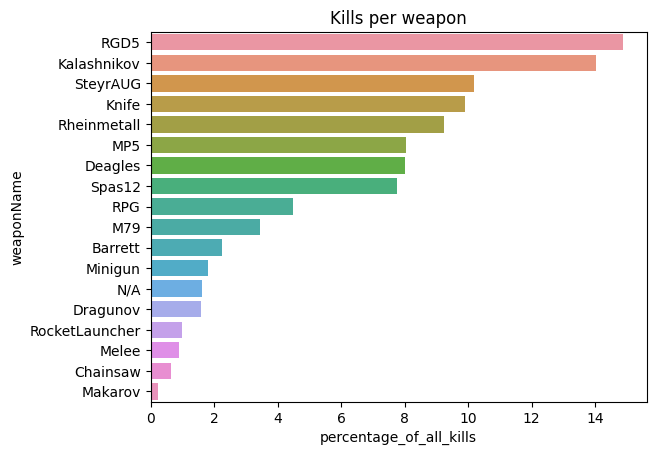

In [13]:
result8 = pd.read_sql_query(
    "select weaponName, round(100.0*count(1)/(select count(1) from event_kill ek),2) as percentage_of_all_kills from event_kill group by weaponName order by percentage_of_all_kills desc", con)
sns.barplot(result8,
            y="weaponName", x="percentage_of_all_kills").set(title="Kills per weapon")

In [14]:
result8

,weaponName,percentage_of_all_kills
0,RGD5,14.87
1,Kalashnikov,14.03
2,SteyrAUG,10.18
3,Knife,9.89
4,Rheinmetall,9.25
5,MP5,8.03
6,Deagles,8.02
7,Spas12,7.76
8,RPG,4.48
9,M79,3.45
